In [1]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/522'

role = sagemaker.get_execution_role()

In [2]:
!pip install nilearn
!pip install torch
!pip install torchvision
!pip install tqdm

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np
import tqdm
import os
import nibabel as nib
import pandas as pd
import nilearn
import os
import datetime
import torch
import random
from matplotlib import pyplot as plt
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# !unzip native_2.zip
# !unzip native_1.zip

In [5]:
nib_images = []
nib_lesions = []

In [6]:
for subdir in os.listdir('native_1'):
    if subdir != '.DS_Store':
        look = 'native_1' + '/' + subdir
        for subsubdir in os.listdir(look):
            if subsubdir != '.DS_Store':
                sublook = look + '/' + subsubdir
                nib_images.append(nib.load(sublook + '/' + subsubdir +'.nii.gz'))
                nib_lesions.append(nib.load(sublook + '/' + subsubdir + '_LesionSmooth.nii.gz'))

In [7]:
for subdir in os.listdir('native_2'):
    if subdir != '.DS_Store':
        look = 'native_2' + '/' + subdir
        for subsubdir in os.listdir(look):
            if subsubdir != '.DS_Store':
                sublook = look + '/' + subsubdir
                nib_images.append(nib.load(sublook + '/' + subsubdir +'.nii.gz'))
                nib_lesions.append(nib.load(sublook + '/' + subsubdir + '_LesionSmooth.nii.gz'))

In [9]:
d = [48, 56, 62, 64]

In [41]:
def get_features_train(brain, lesion,num):
    s0, s1, s2 = brain.shape
    ran = 0.009
    features = []
    flat_feat = []
    labels = []
    flat_lab = []
    for k in range(s2-50):
        for i in range(s0 - 100):
            for j in range(s1 - 100):
                if lesion[i+50, j+50, k+25] != 0 or random.random() < ran:
                    selection = brain[i+38:i+63, j+38:j+63, k+25]
                    l_selection = lesion[i+50, j+50, k+25]
                    features.append(selection)
                    labels.append(l_selection)
                    if num < 5:
                        flat_feat.append(selection.reshape(selection.shape[0]**2))
                        flat_lab.append(l_selection)
    return features, labels, flat_feat, flat_lab

In [60]:
def get_features_rf(brain, lesion):
    s0, s1, s2 = brain.shape
    ran = 0.04
    ran2 = 0.005
    # num = (s0 - 50) * (s1 - 50) * s2
    flat_feat = []
    flat_lab = []
    for k in range(s2-50):
        for i in range(s0 - 100):
            for j in range(s1 - 100):
                l = lesion[i+50, j+50, k+25]
                if (l==1 and random.random()<ran2) or (l==0 and random.random() < ran):
                    selection = brain[i+38:i+63, j+38:j+63, k+25]
                    l_selection = lesion[i+50, j+50, k+25]
                    flat_feat.append(selection.reshape(selection.shape[0]**2))
                    flat_lab.append(l_selection)
    return flat_feat, flat_lab

In [103]:
def get_features_test(brain, lesion):
    s0, s1, s2 = brain.shape
    ran = 0.03
    ran2 = 0.2
    # num = (s0 - 50) * (s1 - 50) * s2
    features = []
    labels = []
    for k in range(s2-50):
        for i in range(s0 - 100):
            for j in range(s1 - 100):
                l = lesion[i+50, j+50, k+25]
                if (l==1 and random.random()<ran2) or (l==0 and random.random() < ran):
                    selection = brain[i+38:i+63, j+38:j+63, k+25]
                    l_selection = lesion[i+50, j+50, k+25]
                    features.append(selection)
                    labels.append(l_selection)
    return features, labels

In [12]:
max_size = (256, 256, 185)
def padding(brain, lesion):
    padded_brain = np.zeros(max_size)
    padded_lesion = np.zeros(max_size)
    s0, s1, s2 = brain.shape

    h = int(np.floor((max_size[0] - s0)/2))
    w = int(np.floor((max_size[1] - s1)/2))
    f = int(np.floor((max_size[2] - s2)/2))

    padded_brain[h:h+s0, w:w+s1, f:f+s2] = brain
    padded_lesion[h:h+s0, w:w+s1, f:f+s2] = lesion

    return padded_brain, padded_lesion

In [42]:
# Store Slices Here
brain_data = []
X_train = []
lesion_data = []
y_train = []
for i in tqdm.tqdm(range(25)):
    if i not in d: # where brain sizes and lesion sizes are different
        img, lesion = nib_images[i], nib_lesions[i]
        # normalize
        brain = img.get_fdata()/255
        lesion = lesion.get_fdata()/255
        #reshape for consistency
        if i < 31:
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        elif i > 85:
          brain = np.swapaxes(brain,1,2).copy()
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.swapaxes(lesion,1,2).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        brain = exposure.equalize_hist(brain)
        #slice
        if brain.shape[0:2] < (50, 50):
            continue
        features, labels, flattened_X, flattened_y = get_features_train(brain, lesion,i)
        
#         print(features[0].shape)
        brain_data.extend(features)
        lesion_data.extend(labels)
        X_train.extend(flattened_X)
        y_train.extend(flattened_y)

100%|██████████| 25/25 [02:38<00:00,  6.36s/it]


In [104]:
# Store Slices Here
brain_data_valid = []
lesion_data_valid = []
X_valid = []
y_valid = []
for i in tqdm.tqdm(range(50,60)):
    if i not in d: # where brain sizes and lesion sizes are different
#         if i%10 == 0:
#           print(i)
        img, lesion = nib_images[i], nib_lesions[i]
        # normalize
        brain = img.get_fdata()/255
        lesion = lesion.get_fdata()/255
        #reshape for consistency
        if i < 31:
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        elif i > 85:
          brain = np.swapaxes(brain,1,2).copy()
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.swapaxes(lesion,1,2).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        #slice
        if brain.shape[0:2] < (50, 50):
            continue
        features, labels= get_features_test(brain, lesion)
        flattened_X, flattened_y = get_features_rf(brain, lesion)
        brain_data_valid.extend(features)
        lesion_data_valid.extend(labels)
        X_valid.extend(flattened_X)
        y_valid.extend(flattened_y)

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


In [11]:
# Store Slices Here
brain_data_test= []
lesion_data_test = []
X_test = []
y_test = []
for i in tqdm.tqdm(range(50,60)):
    if i not in d: # where brain sizes and lesion sizes are different
        img, lesion = nib_images[i], nib_lesions[i]
        # normalize
        brain = img.get_fdata()/255
        lesion = lesion.get_fdata()/255
        #reshape for consistency
        if i < 31:
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        elif i > 85:
          brain = np.swapaxes(brain,1,2).copy()
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.swapaxes(lesion,1,2).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        #slice
        if brain.shape[0:2] < (50, 50):
            continue
        features, labels= get_features_test(brain, lesion)
        flattened_X, flattened_y = get_features_rf(brain, lesion)
        brain_data_test.extend(features)
        lesion_data_test.extend(labels)
        X_test.extend(flattened_X)
        y_test.extend(flattened_y)

100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


In [18]:
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

In [19]:
class BrainsDataset(Dataset):
    def __init__(self, brains, lesions, transform=None):
        self.brains = brains
        self.lesions = lesions
        self.transform = transform

    def __len__(self):
        return len(self.brains)

    def __getitem__(self, idx):
        sample = {'brain': self.brains[idx], 'lesion': self.lesions[idx]}
        if self.transform:
            sample['brain'] = self.transform(sample['brain'])
        return sample

In [107]:
input_transforms = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize(mean=0.56,std=0.41)])
brains_dataset = BrainsDataset(brain_data, lesion_data, transform=input_transforms)
brains_valid = BrainsDataset(brain_data_valid, lesion_data_valid, transform=input_transforms)
brains_test = BrainsDataset(brain_data_test, lesion_data_test, transform=input_transforms)
dataloader = DataLoader(brains_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(brains_valid, batch_size = 256, shuffle=False)
test_dataloader = DataLoader(brains_test, batch_size = 256, shuffle=False)

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
rf = RandomForestClassifier(n_jobs=-1,n_estimators=50, max_depth=6).fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [64]:
dice(y_pred, y_test)

352.0


0.015063334474495036

In [115]:
resnet18 = models.resnet18(pretrained=True)

In [116]:
def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for name, param in model.named_parameters(): #.children()
      if name[:9] == 'layer4.0.' :  param.requires_grad = True
      else: param.requires_grad = False

set_parameter_requires_grad(resnet18, feature_extracting = True)

In [117]:
num_classes = 2 #We are predicting if a cell is either in or out of the lesion, right? 

last_input = resnet18.fc.in_features
resnet18.fc = nn.Linear(last_input, num_classes)
#print(resnet18)

In [118]:
def dice(true, pred):
  true = np.array(true)
  pred = np.array(pred)
  intersection = np.sum(true*pred)
  union = np.sum(true == 1) + np.sum(pred == 1)
  print(intersection)
  return 2*intersection/union

In [119]:
# resnet requires 3 channels
conv = nn.Conv2d(1,3,5,1,2).to(device)

In [121]:
def train_model(train_dataloader, optimizer, loss, net, test_dataloader):
  # TODO: Insert your code here
  net = net.to(device)
  true = np.array([])
  preds = np.array([])
  interval_losses = []
  for epoch in range(1):
    interval_loss = 0
    print(datetime.datetime.now())
    total_loss = 0
    total = 0
    correct = 0
    epoch_iterator = tqdm.tqdm(train_dataloader)
    
    for num, data in enumerate(epoch_iterator):
      inputs, labels = data['brain'], data['lesion']
      inputs, labels = inputs.float().to(device), labels.float().to(device)

      optimizer.zero_grad()
      inputs = conv(inputs.float())
      outputs = net(inputs)
      _, pred = torch.max(outputs, 1)
      np.append(preds, pred.cpu().numpy())
      np.append(true, labels.cpu().numpy())
      loss_value = loss(outputs, labels.long())
    
      if num%200 == 0 and num!=0:
        interval_losses.append(interval_loss/200)
        interval_loss = 0
      loss_value.backward()

      interval_loss += loss_value.item()
      optimizer.step()
        
      total_loss += loss_value.item()
    
      total += len(labels)
    print(f"Epoch: {epoch}, Loss: {total_loss/total}, Dice: {test_model(test_dataloader, net)}")
    print()
    
  return interval_losses

In [122]:
def test_model(test_dataloader, net):
  # TODO: Insert your code here
  correct = 0
  total = 0
  output_list = np.array([])
  true = np.array([])
  with torch.no_grad():
    for data in tqdm.tqdm(test_dataloader):
      inputs, labels = data['brain'], data['lesion']
      inputs, labels = inputs.float().to(device), labels.float().to(device)
    
      inputs = conv(inputs.float())
      outputs = net(inputs)
      pred = torch.max(outputs, 1)[1]
      output_list = np.append(output_list, pred.cpu().numpy())
      true = np.append(true, labels.cpu().numpy())

    print(np.count_nonzero(output_list))
    print(np.count_nonzero(true))
    return dice(np.array(output_list), np.array(true))
      

In [115]:
optimizer = optim.Adam(resnet18.parameters(), lr=1e-5)
loss_function = nn.CrossEntropyLoss()
losses = train_model(dataloader, optimizer, loss_function, resnet18, val_dataloader)

  0%|          | 0/10740 [00:00<?, ?it/s]

2020-05-07 05:52:23.770805


  0%|          | 0/1874 [00:00<?, ?it/s]

545572.0321578257


100%|██████████| 1874/1874 [01:22<00:00, 22.84it/s]

17254 
 2054 
 520.0 
 Epoch: 0, Loss: 0.12457895423548721, Train Dice: 0.657124568723548695, Valid Dice: 0.1521546621458879


Text(0, 0.5, 'Training Loss')

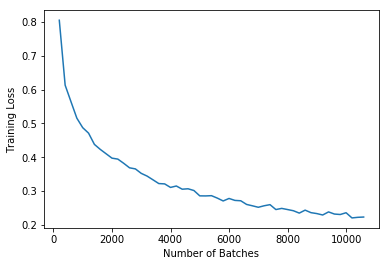

In [124]:
plt.plot(np.arange(200,10800,200), losses)
plt.xlabel('Number of Batches')
plt.ylabel('Training Loss')

In [6]:
test_model(test_dataloader, resnet18)

176164 
23272 
150085.0


0.14596618609999715